<a href="https://colab.research.google.com/github/iamdsc/humor_detection/blob/master/humor_detection_with_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Humor Detection with Deep Learning using Keras

## Getting the data

In [0]:
# Load in the dataset
!git clone https://github.com/iamdsc/humor_detection.git

Cloning into 'humor_detection'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 22 (delta 5), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [0]:
%cd humor_detection/datasets
!ls

/content/humor_detection/datasets
humorous_oneliners.pickle      proverbs.pickle		 wiki_sentences.pickle
oneliners_incl_doubles.pickle  reuters_headlines.pickle


In [0]:
# Read in the lists of sentences from respective pickle files
import pandas as pd


humour = pd.read_pickle('humorous_oneliners.pickle')
proverb = pd.read_pickle('proverbs.pickle')
wiki = pd.read_pickle('wiki_sentences.pickle')
long_humour = pd.read_pickle('oneliners_incl_doubles.pickle')
reuters = pd.read_pickle('reuters_headlines.pickle')

## Pre-processing the dataset

In [0]:
import numpy as np


texts = []
labels = []

# shuffling the different negative samples
neg = proverb+wiki+reuters
np.random.shuffle(neg)

# adding the positive samples
print('No. of positive samples',len(humour))
for line in humour:
  texts.append(line)
  labels.append(1)
  
# taking equal samples from both classes
neg = neg[:len(humour)]

# adding the negative samples
print('No. of negative samples',len(neg))
for line in neg:
  texts.append(line)
  labels.append(0)
  
print('Total no. of samples',len(texts))

No. of positive samples 5251
No. of negative samples 5251
Total no. of samples 10502


In [0]:
# Tokenizing the data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


maxlen = 50 # cut off sentences after 50 words
max_words = 10000 # only consider top 10000 common words in dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens'%len(word_index))

# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.array(labels)

print('Shape of data tensor:',data.shape)
print('Shape of labels tensor:',labels.shape)

# shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Using TensorFlow backend.


Found 16837 unique tokens
Shape of data tensor: (10502, 50)
Shape of labels tensor: (10502,)


## Loading the pre-trained word embeddings

In [0]:
# due to small size of dataset
# we would use standford's GloVe pre-trained word embeddings

# download the GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-03-21 05:44:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-03-21 05:44:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.04MB/s    in 6m 54s  

2019-03-21 05:51:42 (1.98 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [11]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [12]:
# parsing the GloVe word-embeddings file
embeddings_index = {}

f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors:'%len(embeddings_index))

Found 400000 word vectors:


In [0]:
# preparing glove word embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i<max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # for words not in embedding index values will be zeros

## Building the model

### 1. Simple feed-forward network with dense layers on top of embedding layer 

In [47]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.optimizers import RMSprop


model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                320064    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
_________________________________________________________________


In [0]:
# load pre-trained word embeddings into the embedding layer and freeze it
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [49]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 3s 348us/step - loss: 0.3833 - acc: 0.8397 - val_loss: 0.2854 - val_acc: 0.8982
Epoch 2/20
9451/9451 [==============================] - 2s 224us/step - loss: 0.2632 - acc: 0.8920 - val_loss: 0.2577 - val_acc: 0.9010
Epoch 3/20
9451/9451 [==============================] - 2s 225us/step - loss: 0.2360 - acc: 0.9037 - val_loss: 0.2478 - val_acc: 0.8991
Epoch 4/20
9451/9451 [==============================] - 2s 246us/step - loss: 0.2160 - acc: 0.9141 - val_loss: 0.2414 - val_acc: 0.8991
Epoch 5/20
9451/9451 [==============================] - 2s 246us/step - loss: 0.2027 - acc: 0.9224 - val_loss: 0.2370 - val_acc: 0.9010
Epoch 6/20
9451/9451 [==============================] - 2s 214us/step - loss: 0.1877 - acc: 0.9271 - val_loss: 0.2358 - val_acc: 0.8915
Epoch 7/20
9451/9451 [==============================] - 2s 211us/step - loss: 0.1778 - acc: 0.9340 - val_loss: 0.2363 - val_acc: 0.8925


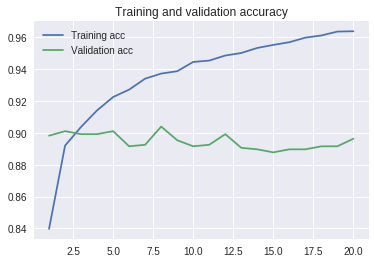

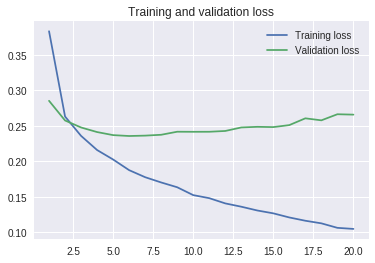

In [50]:
# plotting the results

import matplotlib.pyplot as plt
%matplotlib inline

def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_result(history)

In [52]:
# Building model without pre-trained word embeddings

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                320064    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
_________________________________________________________________
Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 6s 685us/step - loss: 0.6146

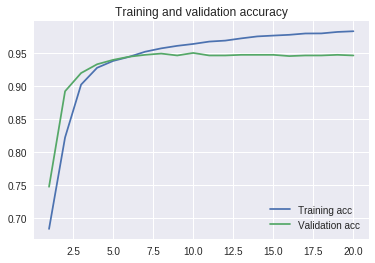

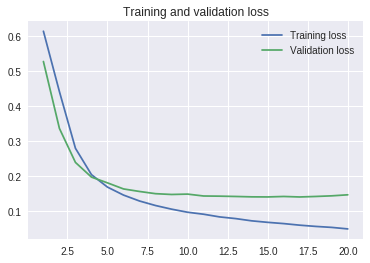

In [53]:
plot_result(history)

### 2. Using Simple RNN layer on top of embedding layer

In [55]:
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(data,labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 5s 560us/step - loss: 0.6518 - acc: 0.6430 - val_loss: 0.6177 - val_acc: 0.5661
Epoch 2/20
9451/9451 [==============================] - 4s 399us/step - loss: 0.5111 - acc: 0.8070 - val_loss: 0.4297 - val_acc: 0.8744
Epoch 3/20
9451/9451 [==============================] - 4s 402us/step - loss: 0.3620 - acc: 0.8798 - val_loss: 0.3272 - val_acc: 0.8982
Epoch 4/20
9451/9451 [==============================] - 4s 399us/step - loss: 0.2475 - acc: 0.9105 - val_loss: 0.2414 - val_acc: 0.9049
Epoch 5/20
9451/9451 [==============================] - 4s 400us/step - loss: 0.2007 - acc: 0.9247 - val_loss: 0.2065 - val_acc: 0.9286
Epoch 6/20
9451/9451 [==============================] - 4s 398us/step - loss: 0.1739 - acc: 0.9341 - val_loss: 0.1922 - val_acc: 0.9382
Epoch 7/20
9451/9451 [==============================] - 4s 397us/step - loss: 0.1570 - acc: 0.9412 - val_loss: 0.1798 - val_acc: 0.9372


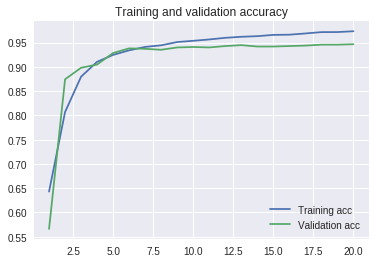

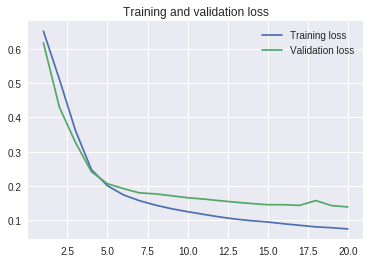

In [57]:
plot_result(history)

### 3. Using LSTM layer on top of the embedding layer

In [0]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_words, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [60]:
model.summary()

model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 13s 1ms/step - loss: 0.6865 - acc: 0.6393 - val_loss: 0.6664 - val_acc: 0.6242
Epoch 2/20
9451/9451 [==============================] - 11s 1ms/step - loss: 0.6176 - acc: 0.6762 - val_loss: 0.5587 - val_acc: 0.7288
Epoch 3/20
9451/9451 [==============================] - 10s 1ms/step - loss: 0.498

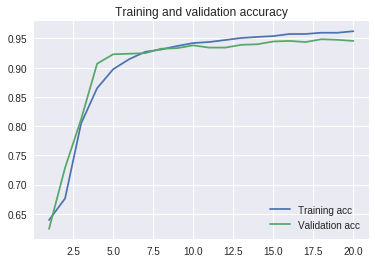

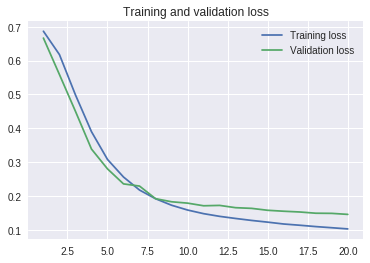

In [61]:
plot_result(history)

### 3. Using Conv1D layer on top of the Embedding layer

In [23]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))

model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 44, 32)            22432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 32)             7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,029,665
Trainable params: 1,029,665
Non-trainable params: 0
_________________________________________________________________


In [24]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 8s 880us/step - loss: 0.6611 - acc: 0.6793 - val_loss: 0.6119 - val_acc: 0.7222
Epoch 2/20
9451/9451 [==============================] - 8s 829us/step - loss: 0.5410 - acc: 0.7534 - val_loss: 0.4512 - val_acc: 0.8059
Epoch 3/20
9451/9451 [==============================] - 8s 845us/step - loss: 0.3758 - acc: 0.8542 - val_loss: 0.3192 - val_acc: 0.8811
Epoch 4/20
9451/9451 [==============================] - 8s 839us/step - loss: 0.2851 - acc: 0.8954 - val_loss: 0.2716 - val_acc: 0.9020
Epoch 5/20
9451/9451 [==============================] - 8s 840us/step - loss: 0.2498 - acc: 0.9072 - val_loss: 0.2548 - val_acc: 0.9058
Epoch 6/20
9451/9451 [==============================] - 8s 834us/step - loss: 0.2310 - acc: 0.9145 - val_loss: 0.2463 - val_acc: 0.9134
Epoch 7/20
9451/9451 [==============================] - 8s 815us/step - loss: 0.2171 - acc: 0.9197 - val_loss: 0.2454 - val_acc: 0.9144


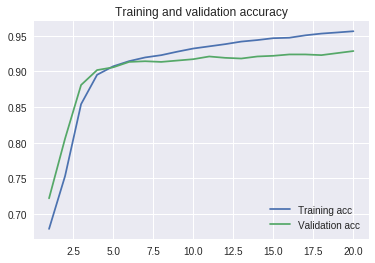

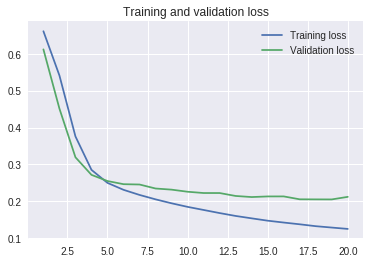

In [25]:
# plot the results
plot_result(history)